# Example Usage
This notebook serves to demonstrate some of the key objects in the MKIDReadout Analysis package. The core idea is to start with a phase time stream object with photons and then apply this to an existing resonator oject using the measurment object. An example phase_timestream, resonator, and measurment is explored in this notebook.

In [56]:
from mkidreadout import MKIDReadout
import mkidnoiseanalysis
from resonator import *
import copy
%matplotlib inline

In [31]:
# Generate a phase time stream
phase_timestream = PhaseTimeStream(fs = 2e6, ts = 20e3)

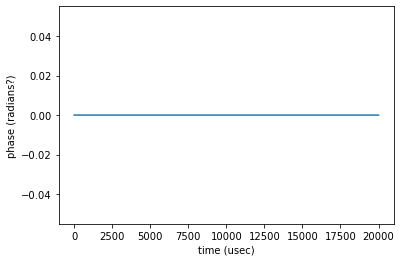

In [32]:
# Plot the raw data
phase_timestream.plot_phasetime(phase_timestream.data_nonoise)

In [33]:
# Define a photon pulse
phase_timestream.gen_photon_pulse(tr=4, tf=30);

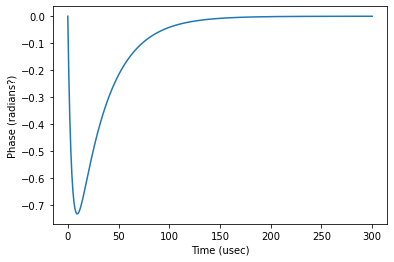

In [34]:
# Plot the pulse
phase_timestream.plot_pulse()

In [35]:
# Generate photon arrival times
phase_timestream.gen_photon_arrivals(cps=500)

array([False, False, False, ..., False, False, False])

In [36]:
# Verify how many photons we got
print(phase_timestream.photon_arrivals.sum())

12


In [37]:
# Populate phase data with photon pulses
phase_timestream.populate_photons()

array([0., 0., 0., ..., 0., 0., 0.])

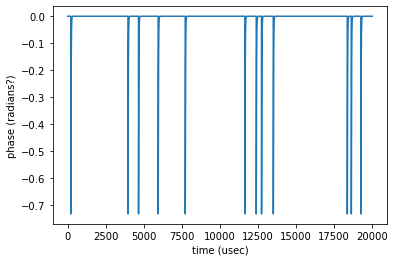

In [38]:
# Plot new phase data
phase_timestream.plot_phasetime(phase_timestream.data_nonoise)

In [39]:
# instantiate an MKIDReadout object which for now only defines the trigger algorithm
readout = MKIDReadout()

# Trigger on photons
readout.trigger(phase_timestream, phase_timestream.data_nonoise)

array([False, False, False, ..., False, False, False])

In [40]:
# Count Triggers
print('Photons:', phase_timestream.photon_arrivals.sum(), 'Triggers:', readout.trig.sum())

Photons: 12 Triggers: 12


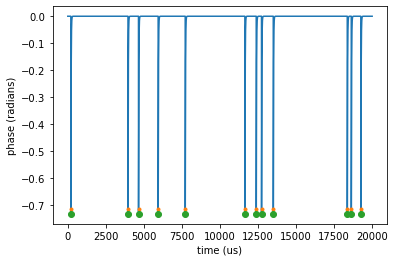

In [41]:
# Record energies of triggered values
readout.record_energies(phase_timestream.data_nonoise)

# Plot trigger events and recorded energies
readout.plot_triggers(phase_timestream, phase_timestream.data_nonoise, energies=True)

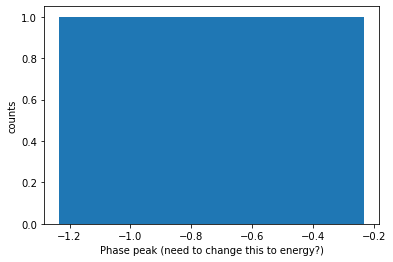

In [44]:
# Plot histogram of "energies"
# This looks like a box because there is no noise
readout.plot_energies()

# Add Noise

In [45]:
phase_timestream.set_tls_noise(scale=1e-3)

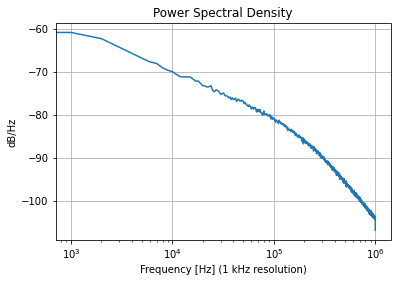

In [46]:
mkidnoiseanalysis.plot_psd(phase_timestream.tls_noise)

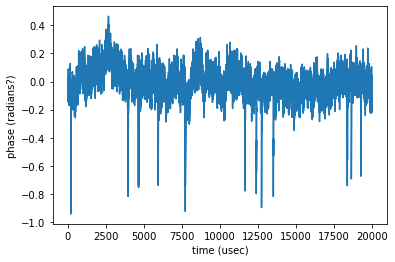

In [47]:
# Plot new phase data
phase_timestream.plot_phasetime(phase_timestream.data)

In [48]:
# Trigger on photons
readout.trigger(phase_timestream, phase_timestream.data, threshold=-0.6, deadtime=30)

array([False, False, False, ..., False, False, False])

In [49]:
# Count Triggers
print('Photons:', phase_timestream.photon_arrivals.sum(), 'Triggers:', readout.trig.sum())

Photons: 12 Triggers: 12


In [50]:
# Record energies of triggered values
readout.record_energies(phase_timestream.data)

array([-0.94179047, -0.81704627, -0.75421544, -0.73902208, -0.9235462 ,
       -0.77877807, -0.79815835, -0.89665044, -0.81823609, -0.74178755,
       -0.69249708, -0.67306788])

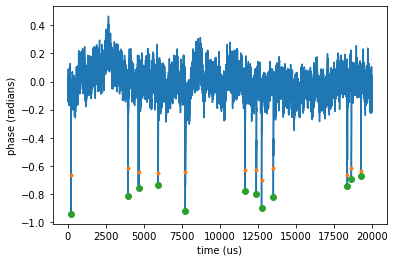

In [51]:
# Plot trigger events with energies
readout.plot_triggers(phase_timestream, phase_timestream.data, energies=True)

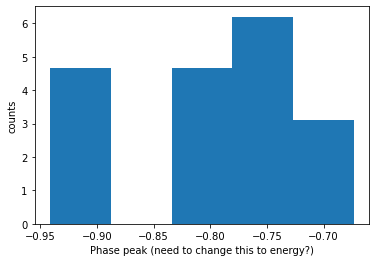

In [52]:
# Plot energy histogram
readout.plot_energies()

# Resonator

In [53]:
# Create resonator and compute S21
resonator = Resonator()
rf = RFElectronics()
freq = FrequencyGrid()
sweep = ResonatorSweep(resonator, freq, rf)

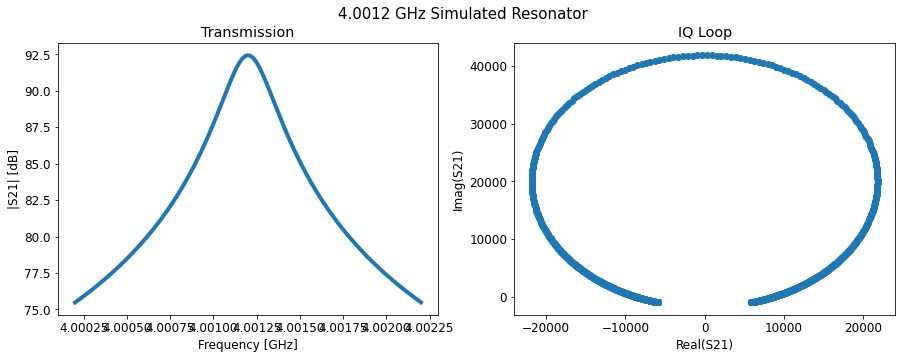

In [54]:
# Plot S21
sweep.plot_sweep()

# Single Photon Event

In [58]:
#Try just one photon and no TLS noise

def pulse(t, t0, tf=30):
    p = np.zeros_like(t)
    p[t >= t0] = -np.exp(-(t[t >= t0] - t0) / tf)
    return p

t = np.linspace(0, 500, 1000)  # in us
photon = pulse(t, 20, tf=30)

phase_timestream_single = copy.deepcopy(phase_timestream)
phase_timestream_single.tls_noise = 0
phase_timestream_single.tvec = t
phase_timestream_single.data_nonoise = photon

In [59]:
# Define Measurment Object
lit_res_measurment = ReadoutPhotonResonator(resonator, phase_timestream_single, freq, rf)

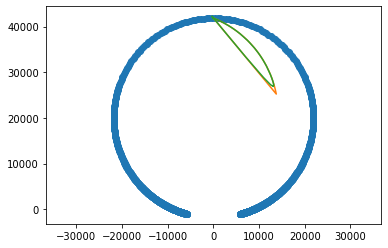

In [60]:
lit_res_measurment.plot_photon_response(sweep.s21)

In [61]:
theta1, d1 = lit_res_measurment.basic_coordinate_transformation()
theta2, d2 = lit_res_measurment.nick_coordinate_transformation()

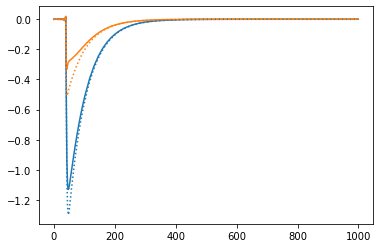

In [62]:
fig, axes = plt.subplots()
axes.plot(theta1, color='C0')
axes.plot(d1, color='C1')
axes.plot(theta2, linestyle=":", color='C0')
axes.plot(d2, linestyle=':', color='C1')

# Try to Look at the Repsonse with Multiple Photons
Now I'm going to perform the same measurment but this time I will use the original `phase_timestream` object with 12 photons.

In [63]:
lit_res_measurment = ReadoutPhotonResonator(resonator, phase_timestream, freq, rf)

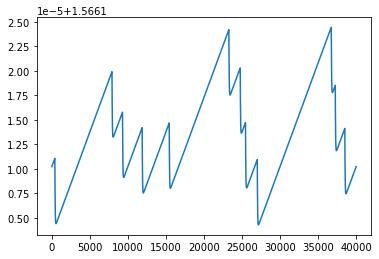

In [64]:
# This does not look how I would expect?
plt.plot(np.angle(lit_res_measurment.iq_response_nonoise))